In [2]:
import random_VQE_data_prep
import pickle
import pandas as pd
import re
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
def count_gate_paris(df, gates:str):
    l = df[gates]
    res = dict()
    for i in range(len(l)):
        tmp = str(l[i])
        if tmp in res.keys():
            res[tmp] += 1
        else:
            res[tmp] = 1
    return res

In [10]:
def extract_features(path):
    file = open(path, "rb")
    dict_ = pickle.load(file)
    #print(dict)
    #print(len(dict["Quantum_circuit"]))
    data = dict_["Quantum_circuit"][0].__dict__["_data"]
    #print(dict["Quantum_circuit"][0].draw())
    

    qubits = str(data)
    #print(qubits)

    # Split input_string before each "CircuitInstruction"
    instructions = qubits.split("CircuitInstruction")

    # Remove the empty string at the beginning (resulting from the initial split)
    instructions = instructions[1:]

    #patterns to get different values from datastring
    pattern_nq = r"num_qubits=(\d+)"
    pattern_nc = r"num_clbits=(\d+)"
    pattern_n = r"name='(\w+)'"
    pattern_p = r"params=\[(.*?)\]"
    pattern_gates = r"Qubit\(QuantumRegister\(5, 'q'\), (\d+)\)"
    #pattern_clb = r'clbits=\(\)\)' -> possibly clbits relevant?

    # Extracted numbers
    # find all values and store them in array to build df
    numbers = [int(match) for match in re.findall(pattern_nq, qubits)]
    clbits = [int(match_cl) for match_cl in re.findall(pattern_nq, qubits)]
    name = [match_name for match_name in re.findall(pattern_n, qubits)]
    params = [match_p for match_p in re.findall(pattern_p, qubits)]

    # loop over all Instructions to get per instruction a list of used qubits
    gates_all = []
    for instr in enumerate(instructions):
        gates = [match_gates for match_gates in re.findall(pattern_gates, str(instr))]
        gates_all.append(gates)


    #create new df to show parameters
    df_new =pd.DataFrame({'name': name, 'num_qubits': numbers, 'num_clbits': clbits, 'params': params, 'gates': gates_all})
    df_new = df_new.sort_values(by='num_qubits', ascending=False)
    df_new = df_new[df_new['num_qubits'] == 2].reset_index()

    res = dict()
    res['noisy_expectation'] = dict_['noisy_expectation']
    res['num_layers'] = dict_['num_layers']
    #res['observable'] = dict_['obervable']
    tmp = count_gate_paris(df_new, 'gates')
    for i in tmp.keys():
        res['count_' + i] = tmp[i]
    res['N2QG'] = len(df_new)
    res['target'] = dict_['ideal_expectation']

    return res 

,noisy_expectation,num_layers,"count_['0', '1']","count_['3', '4']","count_['1', '3']","count_['1', '2']",N2QG,target
0,0.08758,1,2,2,2,2,8,-0.100974
1,-0.04390,4,8,8,8,8,32,0.215809
2,0.20638,4,8,8,8,8,32,0.052419
3,-0.14640,5,10,10,10,10,40,-0.826789
4,0.03688,2,4,4,4,4,16,0.013116
...,...,...,...,...,...,...,...,...
995,0.04128,2,4,4,4,4,16,-0.250453
996,0.02004,3,6,6,6,6,24,-0.232102
997,0.04530,1,2,2,2,2,8,0.015752
998,-0.00074,5,10,10,10,10,40,0.276041


Ridge with alpha = 0: 0.5940820464098878
OLS: 0.5940820464098879


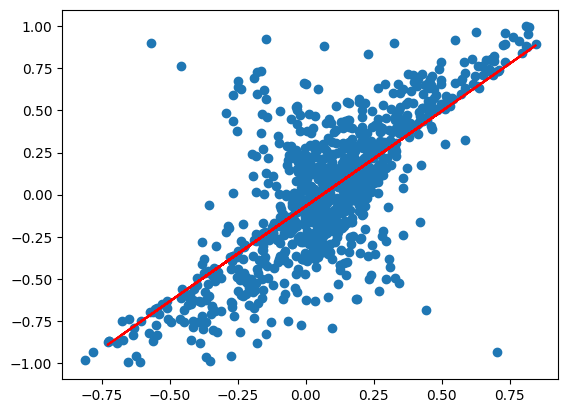

In [11]:
# quick and dirty test for r2-score without using observable
a = list()
for i in range(1000):
    a.append(extract_features(f"./../pickles/circ_{i}.pickle"))
df = pd.DataFrame(a)
display(df)

train_x = df[:900]['noisy_expectation'].to_numpy().reshape(-1, 1)
train_y = df[:900]['target']

test_x = df[900:]['noisy_expectation'].to_numpy().reshape(-1, 1)
test_y = df[900:]['target']

alpha = 0
model = linear_model.Ridge(alpha=alpha)
model = model.fit(train_x, train_y)
print('Ridge with alpha = ' + str(alpha) + ': ' + str(metrics.r2_score(test_y, model.predict(test_x))))

model = linear_model.LinearRegression()
model = model.fit(train_x, train_y)
print('OLS: ' + str(metrics.r2_score(test_y, model.predict(test_x))))

tsne = TSNE(n_components=1)
new_data = tsne.fit_transform(df.drop(columns=['target']))

fig = plt.figure()
ax = fig.add_subplot()#projection='3d')
ax.scatter(df['noisy_expectation'], df['target'])#[new_data[i][1] for i in range(len(new_data))], df['target'])
ax.plot(test_x, model.predict(test_x), color='red')
plt.show()

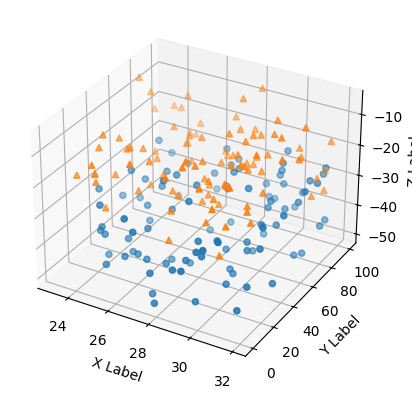

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()